In [1]:
import pandas as pd
from pandas import np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from pandas import np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_log_error, r2_score, make_scorer
from sklearn.model_selection import learning_curve

<ipython-input-1-00970f2cb054>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  from pandas import np
<ipython-input-1-00970f2cb054>:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  from pandas import np


In [2]:
train = pd.read_csv('training.csv', parse_dates=['transaction_date'])
card_group = pd.read_csv('mcc_group_definition.csv')
transaction = pd.read_csv('transaction_types.csv')


In [3]:
train = train.drop(['dataset_transaction','dataset_user'], axis=1)


In [4]:
# merge data
train2 = train.merge(card_group, on='mcc_group', how='left').drop('mcc_group', axis=1)

train2 = (train2
          .merge(transaction, left_on='transaction_type', right_on='type', suffixes=('_card', '_transaction'))
          .drop(['type','transaction_type'], axis=1))


In [92]:
def plot_bar(feature):
    g = sns.catplot(x=feature, 
                    data=train2,
                    order = train2[feature].value_counts().index,
                    kind='count', 
                    height=7, 
                    aspect = 3, 
                    palette="Paired", 
                    edgecolor=".6")
    g.set_xticklabels(rotation=90)

def weekly_popularity_trend(feature, **kwargs):
    """
    Feature popularity on weekly basis
    """
    f = train2.groupby([feature, pd.Grouper(key='transaction_date',freq='W')]).size().reset_index()
    f['transaction_date'] = f['transaction_date'].dt.date
    f.columns = [feature,'transaction_date','count']
    sns.catplot(x="transaction_date", 
            y = 'count',
            hue = feature, 
            data=f, 
            kind='point', 
            height=7, 
            aspect= 1,
            palette='Paired')
    _ = plt.xticks(rotation=90)
    
    
def weekly_currency_trend(**kwargs):
    """
    Mean transaction amount on a weekly basis for a given feature
    """
    feature = kwargs.get('feature', None)
    f = train2.groupby([*feature, pd.Grouper(key='transaction_date',freq='W')])['amount_n26_currency'].mean().reset_index()
    f_std = train2.groupby([*feature, pd.Grouper(key='transaction_date',freq='W')])['amount_n26_currency'].std().reset_index()
    f['transaction_date'] = f['transaction_date'].dt.date
    
    f_std['transaction_date'] = f_std['transaction_date'].dt.date
    f.columns = [*feature,'transaction_date','mean']
    f_std.columns = [*feature,'transaction_date','std']
    
    f_final = f.merge(f_std)
    hue = feature[0]
    
    print(f_final)
    g = sns.catplot(x="transaction_date", 
            y = 'mean',
            hue = feature[0],
            data=f, 
            kind='swarm', 
            height = 7,
            aspect = 1.5,
            palette=sns.color_palette("bright", 10)
            )
    g.set_xticklabels(rotation=90)
    x = np.arange(len(f['mean']))
    plt.errorbar(x,f_final['mean'],yerr=f_final['std'])

   direction transaction_date        mean         std
0         In       2016-02-07  119.343146  160.711511
1         In       2016-02-14  116.322190  167.731252
2         In       2016-02-21  109.235669  164.515148
3         In       2016-02-28  160.328395  227.608916
4         In       2016-03-06  141.213546  185.384919
5         In       2016-03-13  118.525773  169.615062
6         In       2016-03-20  120.875050  169.317519
7         In       2016-03-27  136.058465  202.098626
8         In       2016-04-03  175.773663  224.813875
9         In       2016-04-10  121.037088  161.846864
10        In       2016-04-17  122.923539  179.071488
11        In       2016-04-24  115.364898  166.948927
12        In       2016-05-01  194.175684  245.645962
13        In       2016-05-08  126.990637  172.462974
14        In       2016-05-15  121.074539  174.369679
15        In       2016-05-22  107.427441  161.392301
16        In       2016-05-29  163.265565  236.475116
17        In       2016-06-0

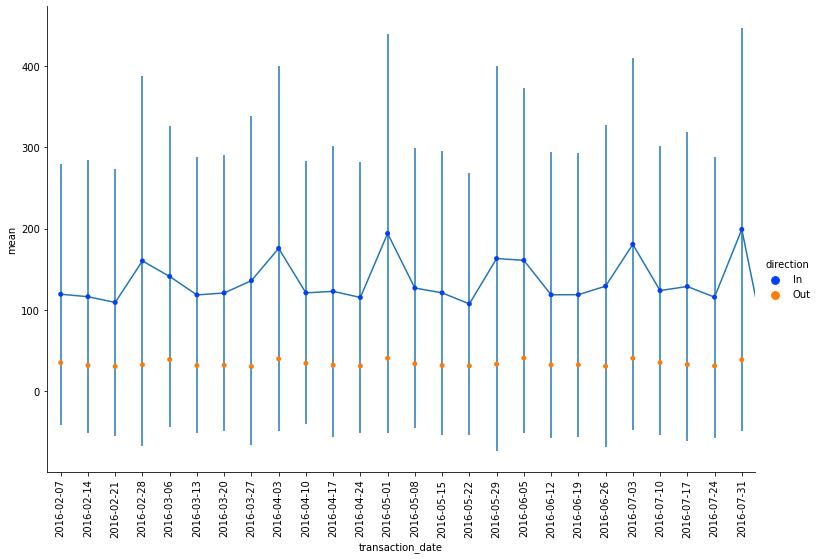

In [94]:
# does not make sense to make a error bar for the direction
weekly_currency_trend(feature = ['direction'])
# let us figure out 


In [95]:
train2

,user_id,transaction_date,amount_n26_currency,explanation_card,explanation_transaction,direction,agent
0,a78884f5e76951188c1e719d4956773a,2016-02-01,350,NaN,Debit Transfer,Out,Bank Account
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,202,NaN,Debit Transfer,Out,Bank Account
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,291,NaN,Debit Transfer,Out,Bank Account
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,214,NaN,Debit Transfer,Out,Bank Account
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,272,NaN,Debit Transfer,Out,Bank Account
...,...,...,...,...,...,...,...
408541,67b86e1168dfe526708ea275ac0a71a8,2016-07-29,11,NaN,Transferwise Transaction,Out,Partner
408542,fff08c7a5cfb93b873149159be9f7976,2016-07-29,40,NaN,Transferwise Transaction,Out,Partner
408543,2018aea439dab366b6ddf6f4df704342,2016-07-29,185,NaN,Transferwise Transaction,Out,Partner
408544,406b16e6a28b54c935763b6598bfa272,2016-07-30,71,NaN,Transferwise Transaction,Out,Partner
